# Data Processing

#### Importing all the necessary python libraries


In [39]:
import csv
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#### Converting all flat structures into nested structures and storing all new nested columns in a list

In [40]:
with open('acw_user_data.csv', mode ='r') as csv_file:
    csv_reader = csv.DictReader( csv_file, delimiter = ',' )
    new_list = []  
    
    for line in csv_reader:
         # Converting string True and False to boolean values
         retired = line["Retired"] = True if line["Retired"] == "True" else False
        
         address = {
            "street" : line["Address Street"],
            "city" : line["Address City"],
            "postcode" : line["Address Postcode"]
         }
         credit_card = {
            "start_date" : line["Credit Card Start Date"],
            "end_date" : line["Credit Card Expiry Date"],
            "number" : int(line["Credit Card Number"]),
            "cvv" : int(line["Credit Card CVV"]),
            "iban" : line["Bank IBAN"]
         }
         vehicle = {
            "make" : line["Vehicle Make"],
            "model" : line["Vehicle Model"],
            "year" : line["Vehicle Year"],
            "catagory" : line["Vehicle Type"],
         }
        # Handling missing dependant values and casting to int
         dependant_nan = line['Dependants']
         dependant_row = int(dependant_nan) if dependant_nan not in ("") else None
        
         new_list.append({"first_name" : line['First Name'], "second_name" : line['Last Name'], "age" : int(line['Age (Years)']), "sex" : line['Sex'], "retired" : retired,  
                         "marital_status" : line['Marital Status'], "dependants" : dependant_row, "salary" : int(line['Yearly Salary (Dollar)']), "pension" : int(line['Yearly Pension (Dollar)']), 
                         "company" : line['Employer Company'], "commute_distance" : float(line['Distance Commuted to Work (Km)']), "Vehicle" : vehicle, "Credit_Card" : credit_card, "Address" : address})


print(new_list)

[{'first_name': 'Kieran', 'second_name': 'Wilson', 'age': 89, 'sex': 'Male', 'retired': True, 'marital_status': 'married or civil partner', 'dependants': 3, 'salary': 72838, 'pension': 7257, 'company': 'N/A', 'commute_distance': 0.0, 'Vehicle': {'make': 'Hyundai', 'model': 'Bonneville', 'year': '2009', 'catagory': 'Pickup'}, 'Credit_Card': {'start_date': '08/18', 'end_date': '11/27', 'number': 676373692463, 'cvv': 875, 'iban': 'GB62PQKB71416034141571'}, 'Address': {'street': '70 Lydia isle', 'city': 'Lake Conor', 'postcode': 'S71 7XZ'}}, {'first_name': 'Jonathan', 'second_name': 'Thomas', 'age': 46, 'sex': 'Male', 'retired': False, 'marital_status': 'married or civil partner', 'dependants': 1, 'salary': 54016, 'pension': 0, 'company': 'Begum-Williams', 'commute_distance': 13.72, 'Vehicle': {'make': 'Nissan', 'model': 'ATS', 'year': '1996', 'catagory': 'Coupe'}, 'Credit_Card': {'start_date': '08/12', 'end_date': '11/26', 'number': 4529436854129855, 'cvv': 583, 'iban': 'GB37UMCO545402287

#### Marking down problematic rows in a new list for dependants column

In [41]:
empty_rows = []
with open('acw_user_data.csv', mode ='r') as csv_file:
    csv_reader = csv.DictReader( csv_file, delimiter = ',' )

# replacing empty strings with 0  
    for i, line in enumerate(csv_reader) :
        empty_values = line["Dependants"]
        if empty_values == "" or empty_values == " " :
            empty_rows.append(i)
            line['Dependants'] = '0'
print("Problematic rows for dependants:" , empty_rows)

Problematic rows for dependants: [21, 109, 179, 205, 270, 272, 274, 358, 460, 468, 579, 636, 679, 725, 822, 865, 917, 931, 983]


#### Creating new json file to store all customer datas as dictionaries

In [42]:
with open('processed.json' , mode = 'w') as process :
    json.dump(new_list, process, indent = 4)

In [43]:
with open('processed.json' , mode = 'r') as process :
    processed = json.load(process)

#### Retired customers and Employed customers stored in two different json files

In [48]:
retired_list = []
employed_list = []

for new_line in new_list:
    if isinstance(new_line, dict) and new_line.get("retired") is True :   #isinstance() returns true (w3Schools)
        retired_list.append(new_line)
    employed = new_line.get("company")
    if employed not in "N/A" :
        employed_list.append(new_line)        

with open('retired.json' , mode = 'w') as retired :
    json.dump(retired_list, retired, indent = 4)
with open('employed.json' , mode = 'w') as employed :
    json.dump(employed_list, employed, indent = 4)

#### Calculating expiry date of credit cards and storing in a new json file

In [49]:
def card_expiry(line):
    try:
        if "Credit_Card" not in line:   # one dictionary not having CC throws key error 
            return False
            
        start_date = line["Credit_Card"]["start_date"]  # taking start MM/YY from CC section
        end_date = line["Credit_Card"]["end_date"]    # taking end MM/YY from CC section
        
        
# Splitting months and years by using split(/), 0 index for months and 1 index for years
    
        start_month = int(start_date.split("/")[0])
        start_year = int(start_date.split("/")[1])  
        end_month = int(end_date.split("/")[0])
        end_year = int(end_date.split("/")[1]) 
    
        years_to_months = (end_year - start_year) * 12  #converting years into months
        months = (end_month - start_month)
        difference = years_to_months + months
        
        return difference > 120   # 10 years = 120 months

    except Exception as exception :
        return False


#### Storing the flagged cards in a new json file

In [50]:
flagged_cards = []
for line in new_list:
    if card_expiry(line) :
        flagged_cards.append(line)

with open("remove_ccard.json" , mode = 'w') as json_file :
    json.dump(flagged_cards, json_file, indent = 4)
    

#### Calculating Salary-Commute values and storing as a new data metric

In [51]:
salary_commute_list = []
with open('processed.json', mode = 'r') as json_file :
    rank = json.load(json_file)

for line in rank :
    salary = line["salary"]
    commute_distance = line["commute_distance"]

    #Checking distance if it is equal or less than 1 km and adding to new salary-commute column
    if commute_distance <= 1 :
        line["Salary-Commute"] = salary
    else :
        line["Salary-Commute"] = salary/commute_distance

    salary_commute_list.append(line)  # storing the value as a corresponding dict

#function to return the calculated value and sort the value from dictionary
def salary_commute_value(line):
    return line["Salary-Commute"]   

#sorting the list by each dictionary in ascending order, using column as the key
rank.sort(key = salary_commute_value) 

#### Storing the updated dictionaries in a new json file

In [52]:
with open('commute.json' , mode = 'w') as json_file :
    json.dump(rank, json_file, indent = 4)
    

# Data Visualisation

In [27]:
df = pd.read_csv('acw_user_data.csv')
df

,Address Street,Address City,Address Postcode,Age (Years),Distance Commuted to Work (Km),Employer Company,Credit Card Start Date,Credit Card Expiry Date,Credit Card Number,Credit Card CVV,...,Last Name,Marital Status,Yearly Pension (Dollar),Retired,Yearly Salary (Dollar),Sex,Vehicle Make,Vehicle Model,Vehicle Year,Vehicle Type
0,70 Lydia isle,Lake Conor,S71 7XZ,89,0.00,NaN,08/18,11/27,676373692463,875,...,Wilson,married or civil partner,7257,True,72838,Male,Hyundai,Bonneville,2009,Pickup
1,00 Wheeler wells,Chapmanton,L2 7BT,46,13.72,Begum-Williams,08/12,11/26,4529436854129855,583,...,Thomas,married or civil partner,0,False,54016,Male,Nissan,ATS,1996,Coupe
2,Studio 33K Joel walk,Randallborough,ME3N 1GH,22,16.02,Hill-Wright,11/19,07/27,4091726363083888495,422,...,Jones,married or civil partner,0,False,68049,Male,GMC,Achieva,2015,"Convertible, Coupe"
3,Studio 46S Bethany lights,East Reece,E10 9RJ,56,19.35,Green LLC,10/17,04/18,4671332769487632633,669,...,Shaw,married or civil partner,0,False,91337,Male,Scion,F150 SuperCrew Cab,1994,Pickup
4,Flat 3 Christine views,Fletcherstad,WS2 9SN,57,5.94,"Hill, Evans and Harrison",04/19,11/27,2245094149128526,659,...,O'Brien,married or civil partner,0,False,18446,Female,Buick,Outback,2020,SUV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Studio 6 Heather prairie,North Amelia,E9 0HB,48,18.44,Phillips-Pope,04/19,08/26,3563802099155576,908,...,Clark,married or civil partner,0,False,84645,Male,Saturn,Convertible,2015,Van/Minivan
996,Flat 3 Davies run,Greenshire,E7 4UJ,22,19.61,Hughes LLC,05/12,07/28,3591311819315276,675,...,Jones,married or civil partner,0,False,93314,Female,Toyota,Yukon,2015,Van/Minivan
997,Flat 7 Barber motorway,Burrowsshire,L62 8TA,38,6.66,Bailey Group,01/13,05/29,3584931475767707,679,...,Walker,single,0,False,20940,Female,Ford,S6,2020,Sedan
998,00 Tony forks,Abbiebury,NP4 1JL,45,18.13,Foster-Price,04/19,05/23,4090311300716168,775,...,Thomson,married or civil partner,0,False,82412,Male,Scion,Ram 1500 Quad Cab,2015,Pickup


#### 1. Data Series for salary and age calculations

In [28]:
salary_series = df["Yearly Salary (Dollar)"]
print(salary_series)

0      72838
1      54016
2      68049
3      91337
4      18446
       ...  
995    84645
996    93314
997    20940
998    82412
999    25788
Name: Yearly Salary (Dollar), Length: 1000, dtype: int64


In [29]:
age_series = df["Age (Years)"]
print(age_series)

0      89
1      46
2      22
3      56
4      57
       ..
995    48
996    22
997    38
998    45
999    80
Name: Age (Years), Length: 1000, dtype: int64


In [30]:
print("Mean Salary:", df["Yearly Salary (Dollar)"].mean())
print("Median Age:", df["Age (Years)"].median())


Mean Salary: 57814.078
Median Age: 54.0


#### 2. a) Univariate plot for Age

In [31]:
min_age = df["Age (Years)"].min()
max_age = df["Age (Years)"].max()
bin_num = int((max_age - min_age)/5 + 1)   # +1 and int() to cast into upper ceiling
print("Number of bins required for bin_width of 5 is" , bin_num)

Number of bins required for bin_width of 5 is 15


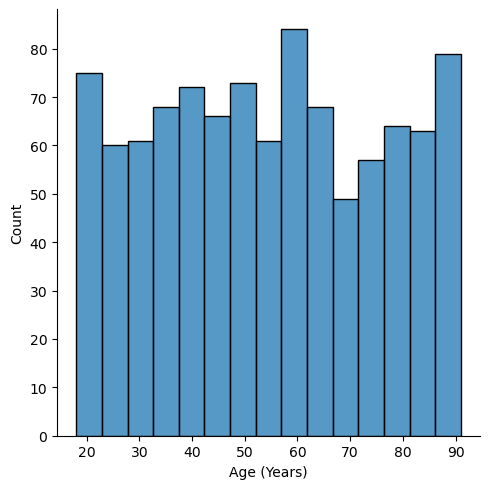

In [32]:
age_plot = sns.displot(df, x = 'Age (Years)', binwidth = 5)

#### 2. b) Univariate plots for Dependants

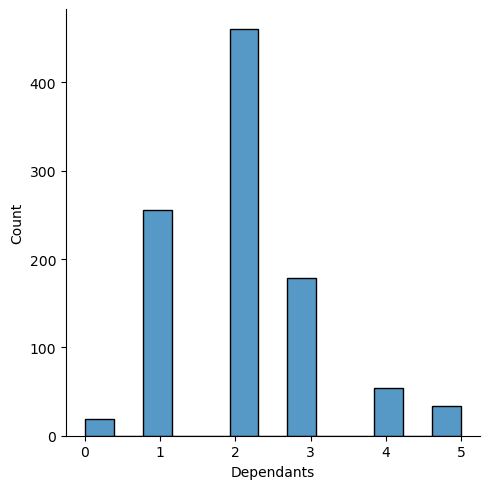

In [33]:
dependants_plot = sns.displot(x = df["Dependants"].fillna(0))

#### 2. c) Age conditioned on marital status

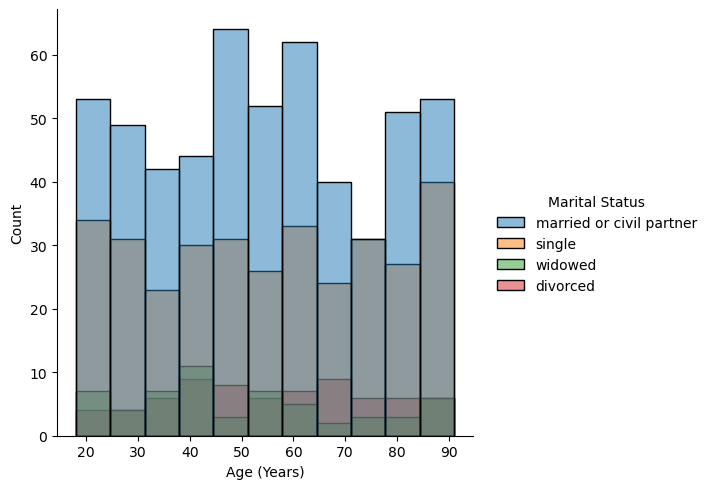

In [34]:
age_status_plot = sns.displot(df, x = 'Age (Years)', hue = 'Marital Status')

#### 3. a) Multivariate : Commuted Distance againts Salary

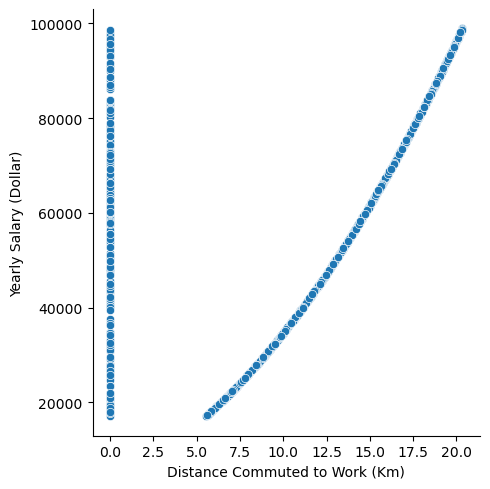

In [35]:
distance_salary_plot = sns.relplot(df, x = 'Distance Commuted to Work (Km)', y = 'Yearly Salary (Dollar)')

#### 3. b) Multivariate : Age againts Salary

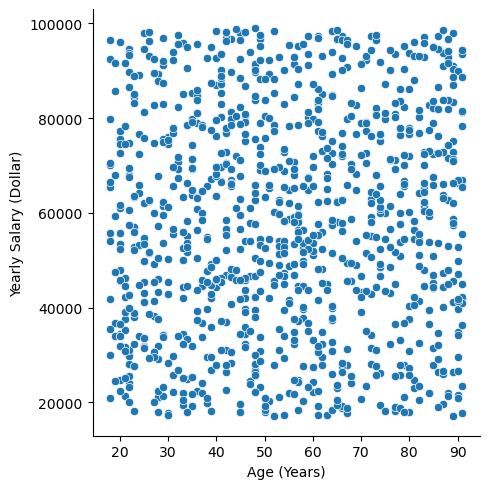

In [36]:
age_salary_plot = sns.relplot(df, x = 'Age (Years)', y = 'Yearly Salary (Dollar)')

#### 3. c) Multivariate : Age againts Salary conditioned by Dependants

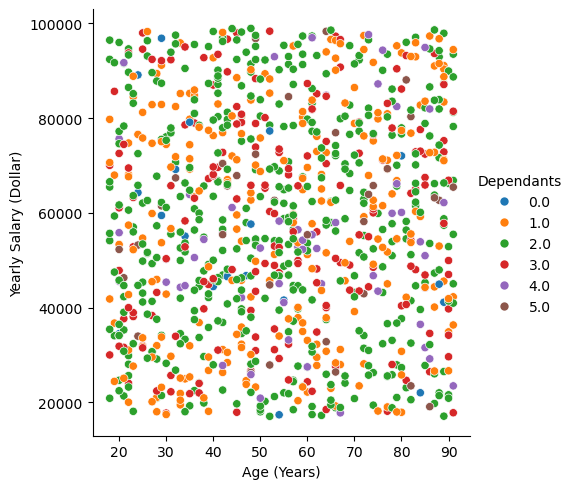

In [53]:
df["Dependants"]= df["Dependants"].fillna(0)
# using palette from seaborn pydata
age_salary_hue = sns.relplot(df, x = 'Age (Years)', y = 'Yearly Salary (Dollar)', hue = 'Dependants', palette = "tab10")

#### 4. Saving all the figures as png

In [54]:
age_plot.savefig("age_plot.png")
dependants_plot.savefig("dependants_plot.png")
age_status_plot.savefig("age_status_plot.png")
distance_salary_plot.savefig("distance_salary_plot.png")
age_salary_plot.savefig("age_salary_plot.png")
age_salary_hue.savefig("age_salary_hue.png")